## BIG DATA NA LOGÍSTICA DO E-COMMERCE
### O uso de dados para otimizar o prazo de entrega ao cliente

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "" --iversions

pandas    : 1.4.2
numpy     : 1.21.5
seaborn   : 0.11.2
matplotlib: 3.5.1



### Explicando o conteúdo dos datasets da Olist que serão utilizados nesta análise:
#### Customers Dataset
Este conjunto de dados contém informações sobre o cliente e sua localização.

#### Order Items Dataset
Este conjunto de dados inclui dados sobre os itens comprados em cada pedido.

#### Payments Dataset
Este conjunto de dados inclui dados sobre as opções de pagamento de pedidos.

#### Order Reviews Dataset
Este conjunto de dados inclui dados sobre as avaliações feitas pelos clientes.

#### Products Dataset
Este conjunto de dados inclui dados sobre os produtos vendidos pela Olist.

#### Sellers Dataset
Esse conjunto de dados inclui dados sobre os vendedores que atenderam aos pedidos feitos na Olist.

#### Order Dataset
Este é o conjunto de dados principal. De cada pedido você pode encontrar todas as outras informações.





## Carregando os dados

In [5]:
file_name ={'orders':'orders', 'items':'items', 'products':'products',
            'customers': 'customers','sellers': 'sellers',
            'payments': 'payments', 'reviews':'reviews'}
for name in file_name.keys():
    locals()[name] = pd.read_csv('dados/'+file_name[name]+'.csv')

In [6]:
# lista todos os conjuntos de dados
dataset_name = file_name.keys()
dataset_name

dict_keys(['orders', 'items', 'products', 'customers', 'sellers', 'payments', 'reviews'])

In [7]:
# Lista todas as colunas do dataset
df_columns_name= pd.DataFrame([globals()[i].columns for i in dataset_name], index = dataset_name).T
df_columns_name

,orders,items,products,customers,sellers,payments,reviews
0,order_id,order_id,product_id,customer_id,seller_id,order_id,review_id
1,customer_id,order_item_id,product_category_name,customer_unique_id,seller_zip_code_prefix,payment_sequential,order_id
2,order_status,product_id,product_name_lenght,customer_zip_code_prefix,seller_city,payment_type,review_score
3,order_purchase_timestamp,seller_id,product_description_lenght,customer_city,seller_state,payment_installments,review_comment_title
4,order_approved_at,shipping_limit_date,product_photos_qty,customer_state,None,payment_value,review_comment_message
5,order_delivered_carrier_date,price,product_weight_g,None,None,None,review_creation_date
6,order_delivered_customer_date,freight_value,product_length_cm,None,None,None,review_answer_timestamp
7,order_estimated_delivery_date,None,product_height_cm,None,None,None,None
8,None,None,product_width_cm,None,None,None,None


In [8]:
# define uma função para obter informações básicas:
# (entradas exclusivas, valor %NaN, dtype) de cada coluna no conjunto de dados
def dataset_info(df, df_name):
    df1 = pd.DataFrame([df.nunique(), df.dtypes, df.isna().sum()*100/len(df)], index=['unique_entries','dtype','NaN_pt(%)']).T
    df1.index.name = "columns_name"
    df1.reset_index(level='columns_name',inplace = True)
    return df1.assign(dataset = df_name)[['dataset'] + df1.columns.tolist()]

In [9]:
# define uma função para destacar NaN_pt(%) > 0:
def highlight_NaN(x):
    return ['color:darkblue;background-color:azure' if v > 0 else '' for v in x]

In [10]:
# "loop for" para percorrer todos os conjuntos de dados 
df_dataset_info = pd.DataFrame()
for dataset in dataset_name: 
    df2 = dataset_info(globals()[dataset], dataset)
    df_dataset_info = df_dataset_info.append(df2)

df_dataset_info.reset_index(drop=True, inplace=True)

df_dataset_format = df_dataset_info.style.apply(highlight_NaN, subset=pd.IndexSlice[:, ["NaN_pt(%)"]])
df_dataset_format

,dataset,columns_name,unique_entries,dtype,NaN_pt(%)
0,orders,order_id,99441,object,0.000000
1,orders,customer_id,99441,object,0.000000
2,orders,order_status,8,object,0.000000
3,orders,order_purchase_timestamp,98875,object,0.000000
4,orders,order_approved_at,90733,object,0.160899
5,orders,order_delivered_carrier_date,81018,object,1.793023
6,orders,order_delivered_customer_date,95664,object,2.981668
7,orders,order_estimated_delivery_date,459,object,0.000000
8,items,order_id,98666,object,0.000000
9,items,order_item_id,21,int64,0.000000


##### Observações:
* Algumas colunas possuem valor NaN que serão tratados no decorrer da análise. 
* As colunas: "review comment title" e "review comment message" no conjunto de dados "reviews" possuem mais de 50% de valores ausentes portanto já serão descartadas.

### A - Analisando os datasets

In [11]:
# dataset "customers" (informações de localização dos clientes)
customers.head()

columns_name,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [12]:
customers.shape

(99441, 5)

In [13]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [14]:
print('Cidades com Vendas: ', customers.customer_city.nunique())
print('Estados com Vendas: ', customers.customer_state.nunique())
print(str.format('Número Médio de Cidades por Estado: {:.0f}', customers.groupby(by='customer_state').customer_city.value_counts().mean()))


Cidades com Vendas:  4119
Estados com Vendas:  27
Número Médio de Cidades por Estado: 23


Text(0, 0.5, 'No. de Clientes')

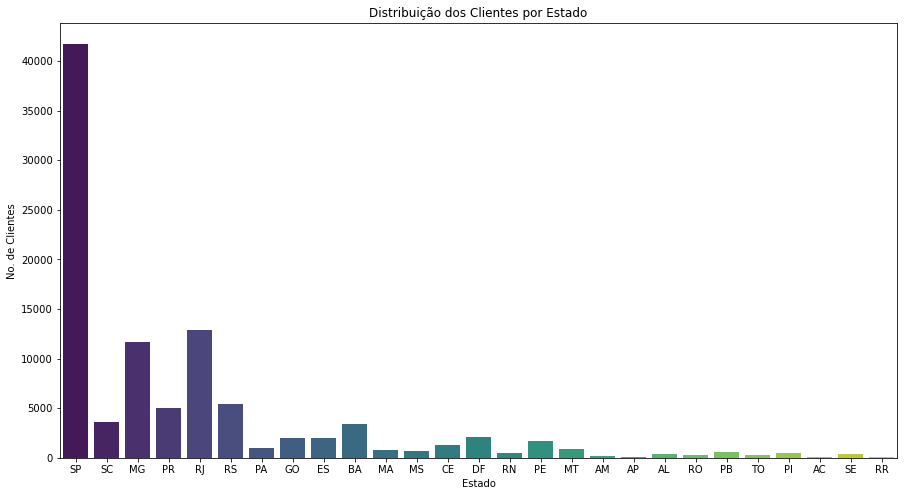

In [15]:
# visualiza a distribuição dos clientes por Estado.
plt.figure(figsize=(15,8))
sns.countplot(x='customer_state', palette = 'viridis', data=customers)
plt.title('Distribuição dos Clientes por Estado')
plt.xlabel('Estado')
plt.ylabel('No. de Clientes')


##### Observações:
* O maior número de clientes se localiza no estado 'SP', seguido por 'RJ' e 'MG', todos situados na região Sudeste do Brasil.
* Os estados de 'AC', 'RR','AP e 'AM', situados na região Norte são os que posuem o menor número de clientes.  

In [16]:
# dataset "items" (itens comprados em cada pedido)
items.head()

columns_name,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [17]:
items.shape

(112650, 7)

In [18]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [19]:
# transforma a coluna 'shipping_limit_date' em datetime
items['shipping_limit_date']=pd.to_datetime(items['shipping_limit_date'])

In [20]:
items.dtypes

columns_name
order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [21]:
# cria uma coluna "dia_semana" para avaliar o envio semanal dos items ao parceiro logistico 
items['dia_semana'] = items.shipping_limit_date.map(lambda x: x.strftime("%A"))

In [22]:
items.head()

columns_name,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,dia_semana
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,Tuesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,Thursday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,Monday


<AxesSubplot:xlabel='dia_semana'>

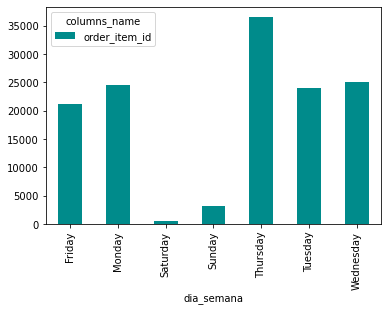

In [23]:
#visualiza o quantidade semanal de itens enviados ao parceiro logistico.
items[['order_item_id','dia_semana']].groupby('dia_semana').sum().plot(kind = 'bar',color = 'darkcyan')

Text(0.5, 0, 'Preço')

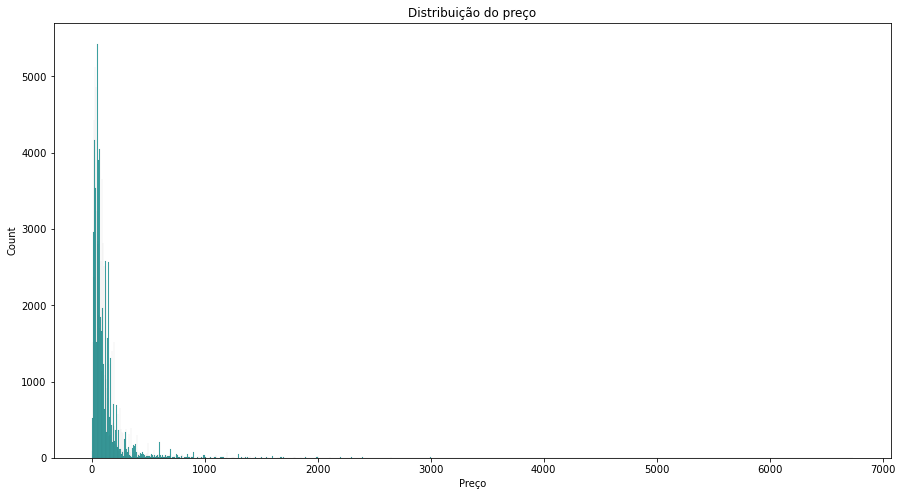

In [24]:
# visualização da distribuição dos preços
plt.figure(figsize=(15,8))
sns.histplot(x='price', color = 'darkcyan', data=items)
plt.title('Distribuição do preço')
plt.xlabel('Preço')


Text(0.5, 0, 'Valor do Frete')

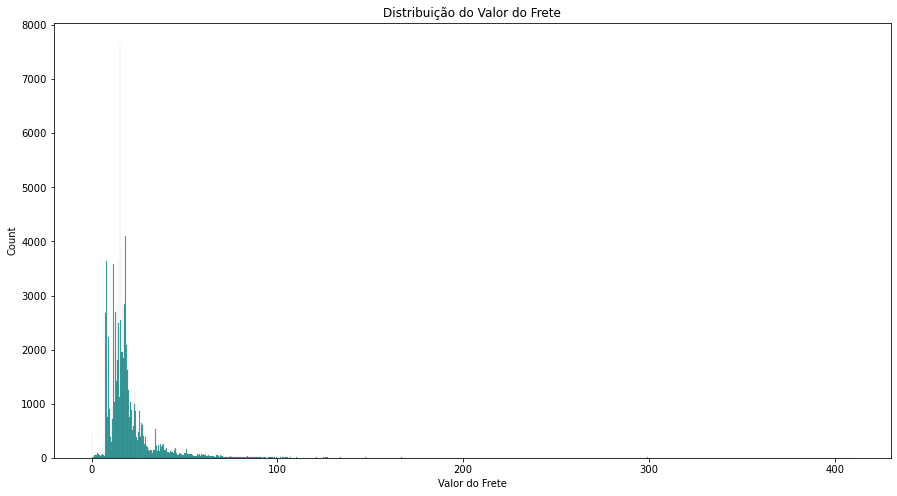

In [25]:
# verifica a distribuição do valor do frete:
plt.figure(figsize=(15,8))
sns.histplot(x='freight_value', color = 'darkcyan',data=items)
plt.title('Distribuição do Valor do Frete')
plt.xlabel('Valor do Frete')


In [26]:
# resumo variáveis preço e frete
items[['price', 'freight_value']].describe()

columns_name,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000


In [27]:
# distribuíção das vendas(Olist) por dia da semana considerando preço e frete
items['price'] = items.price[items.price > 0]
dias = items.groupby("dia_semana")
dias.sum()

columns_name,order_item_id,price,freight_value
dia_semana,,,
Friday,21162,2119002.23,351879.77
Monday,24464,2465891.41,413340.66
Saturday,555,62674.49,9096.73
Sunday,3217,356031.13,56167.23
Thursday,36555,3702324.97,607421.92
Tuesday,23990,2391326.09,402323.68
Wednesday,24993,2494393.38,411679.55


In [28]:
# média da quantidade e do valor de items comprados em cada pedido por dia da semana
dias.mean()

columns_name,order_item_id,price,freight_value
dia_semana,,,
Friday,1.210156,121.175858,20.122363
Monday,1.178988,118.838140,19.920032
Saturday,1.203905,135.953341,19.732603
Sunday,1.166002,129.043541,20.357822
Thursday,1.199468,121.483297,19.931156
Tuesday,1.194781,119.095876,20.037038
Wednesday,1.211019,120.864104,19.947648


##### Observações:
* Quinta-feira aparece como sendo o dia da semana no qual o vendedor envia o maior número de itens comprados para o parceiro logístico: acima de 35.000. No final de samana esse número diminui consideravelmente.
* As vendas durante a semana (segunda a sexta-feira) superam 2 milhões de reais por dia.
* A média de itens comprados é de 1 produto por pedido.
* O preço médio por produto é de 120 reais.
* O valor médio do frete é de 20 reais.

In [29]:
#dataset "payments" (opções de pagamento de pedidos)
payments.head()

columns_name,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [30]:
payments.shape

(103886, 5)

In [31]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


Text(0, 0.5, 'No. de Clientes')

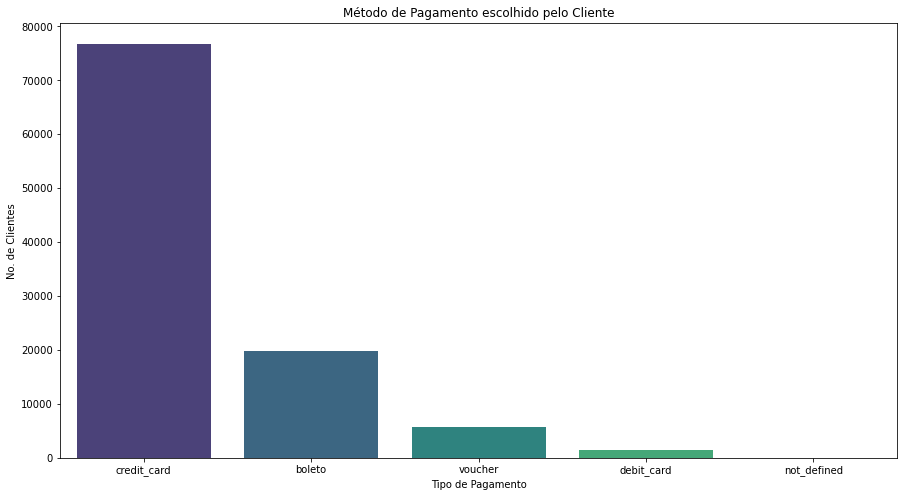

In [32]:
# analisa os tipos de pagamentos por número de clientes
plt.figure(figsize=(15,8))
sns.countplot(x='payment_type', palette = 'viridis', data=payments)
plt.title('Método de Pagamento escolhido pelo Cliente')
plt.xlabel('Tipo de Pagamento')
plt.ylabel('No. de Clientes')


In [33]:
# total de vendas(Olist) por tipo de pagamento
payments['payment_value'] = payments.payment_value[payments.payment_value > 0]
valor = payments.groupby("payment_type")
valor.sum()

columns_name,payment_sequential,payment_installments,payment_value
payment_type,,,
boleto,19785,19784,2869361.27
credit_card,77115,269332,12542084.19
debit_card,1582,1529,217989.79
not_defined,3,3,0.00
voucher,15029,5775,379436.87


In [34]:
# remove o método de pagamento : not_defined 
payments = payments.loc[payments['payment_type']!='not_defined', :]


Text(0, 0.5, 'No. de Clientes')

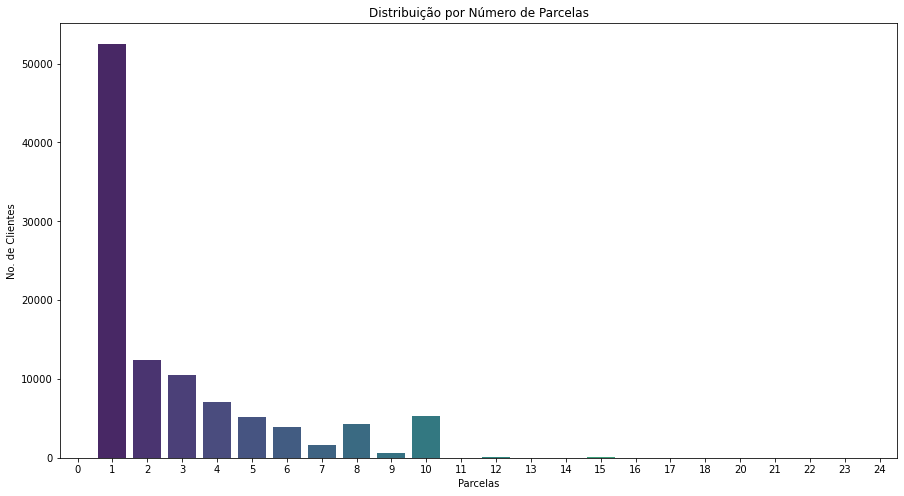

In [35]:
# visualiza a distribuição por número de parcelas
plt.figure(figsize=(15,8))
sns.countplot(x='payment_installments', palette = 'viridis', data=payments)
plt.title('Distribuição por Número de Parcelas')
plt.xlabel('Parcelas')
plt.ylabel('No. de Clientes')


##### observações:
* A maioria dos clientes preferem cartão de crédito, seguido de boleto, voucher e depois cartão de débito.
* A preferência pelo cartão de crédito pode ser pela facilidade do parcelamento da compra, o que é atrativo para o cliente, ou também por ser uma das formas de pagamento mais aceitas pelo comércio de uma maneira geral.
* Oferecer diversos formatos de pagamento, também ajuda a empresa a alcançar maior fidelidade por parte do cliente.
* O tipo 'not_defined' não apresenta informação válida, por isso foi removido.
* A maioria dos clientes prefere o pagamento em apenas uma parcela. Um número pequeno de clientes opta pelo parcelamento em até 10 parcelas.

In [36]:
# dataset "reviews" (avaliações feitas pelos clientes)
reviews.head()

columns_name,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [37]:
reviews.shape

(99224, 7)

In [38]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [39]:
# como temos mais de 50% valores "missing" no dataset "reviews"  nas colunas 'review_comment_title' e 
#'review_comment_message' vamos deletá-las.
reviews = reviews.drop(columns=['review_comment_title', 'review_comment_message'])

Text(0, 0.5, 'No. de Avaliações')

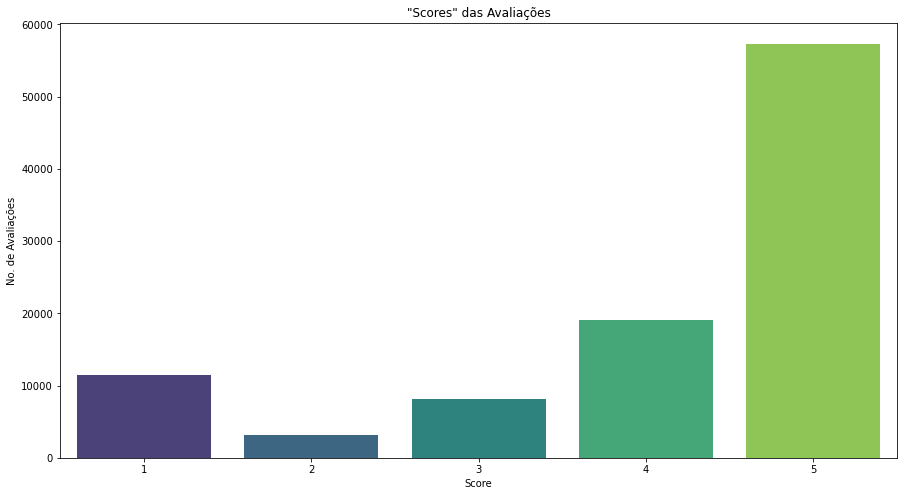

In [40]:
# verifica os "scores" das avaliações feitas pelos clientes:
plt.figure(figsize=(15,8))
sns.countplot(x='review_score', palette = 'viridis', data=reviews)
plt.title('"Scores" das Avaliações')
plt.xlabel('Score')
plt.ylabel('No. de Avaliações')


In [41]:
reviews['review_score'].value_counts().to_frame()

,review_score
5,57328
4,19142
1,11424
3,8179
2,3151


##### Observações:
* A maioria dos clientes classificou o serviço entre 4 e 5, o que significa que ficaram satisfeitos. 
* Porém observa-se também que muitos clientes deram 1, apontando descontentamento em relação ao serviço.

In [42]:
# dataset "products" ( dados sobre os produtos vendidos)
products.head()

columns_name,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [43]:
products.shape

(32951, 9)

In [44]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [45]:
# Top 20 -  categoria dos produtos
products['product_category_name'].value_counts().head(20).to_frame()

,product_category_name
cama_mesa_banho,3029
esporte_lazer,2867
moveis_decoracao,2657
beleza_saude,2444
utilidades_domesticas,2335
automotivo,1900
informatica_acessorios,1639
brinquedos,1411
relogios_presentes,1329
telefonia,1134


In [46]:
products['product_weight_g'].value_counts().to_frame()

,product_weight_g
200.0,2084
300.0,1561
150.0,1259
400.0,1206
100.0,1188
...,...
6075.0,1
822.0,1
631.0,1
2925.0,1


#### Observação:
* O peso em gramas da maior parte dos produtos varia de 100 a 400 gramas. 
* A categoria cama/mesa/banho é a mais vendida.

In [47]:
#dataset "sellers" (mostra a localidade dos vendedores)
sellers.head()

columns_name,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [48]:
sellers.shape

(3095, 4)

In [49]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


Text(0, 0.5, 'No. de vendedores')

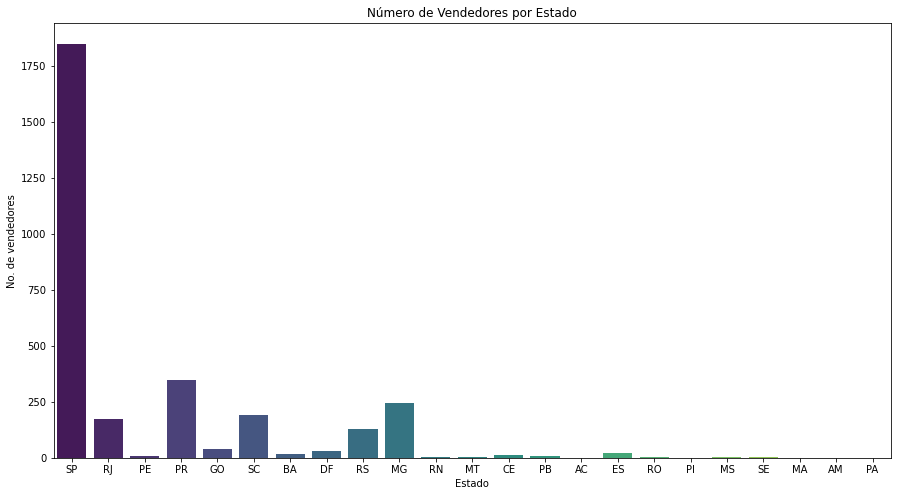

In [50]:
#visualizando o número de vendedores por estado
plt.figure(figsize=(15,8))
sns.countplot(x='seller_state',  palette = 'viridis', data=sellers)
plt.title('Número de Vendedores por Estado')
plt.xlabel('Estado')
plt.ylabel('No. de vendedores')


##### Observação 
* A maioria dos vendedores são do estado 'SP', assim como a maioria dos clientes conforme já visto.

In [51]:
# dataset 'orders' (conjunto de dados principal)
orders.head()

columns_name,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [52]:
orders.shape

(99441, 8)

In [53]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [54]:
# Como temos menos de 20% de valores ausentes, comparados ao tamanho do dataset 
#então removeremos as linhas que possuem valores NaN usando a função dropna()
orders = orders.dropna()

In [55]:
orders.order_status.value_counts().to_frame()

,order_status
delivered,96455
canceled,6


##### Observação
* O status predominante para a maioria dos produtos é "delivered", ou seja "entregue". Apenas 6 aparecem como cancelados. Sendo assim a decisão é de analisar somente os pedidos entregues. 

In [56]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96461 non-null  object
 1   customer_id                    96461 non-null  object
 2   order_status                   96461 non-null  object
 3   order_purchase_timestamp       96461 non-null  object
 4   order_approved_at              96461 non-null  object
 5   order_delivered_carrier_date   96461 non-null  object
 6   order_delivered_customer_date  96461 non-null  object
 7   order_estimated_delivery_date  96461 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


In [57]:
# Mudaremos as colunas de "data" de objeto para formato "date"
orders[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
        'order_delivered_customer_date','order_estimated_delivery_date']] =  orders[
        ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
         'order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)

In [58]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


In [59]:
# Vamos nos basear somente nos pedidos entregues para verificarmos o tempo de entrega
delivered = orders[orders['order_status']=='delivered']

In [60]:
delivered.shape

(96455, 8)

### B - Engenharia de Atributos  - Redimensionando os dados

#### Feature Extraction
#### Aqui faremos a extração de novas variáveis a partir da informação contida em outras variáveis, e tomaremos a decisão sobre quais variáveis serão usadas na Engenharia de Atributos.

#### Combinando os datasets

In [61]:
data_delivered = pd.merge(delivered,customers,on='customer_id',how='left')
review = pd.merge(reviews,data_delivered,on='order_id',how='left')
orders_products = pd.merge(review,items,on='order_id',how='left')
products = pd.merge(orders_products,products,on='product_id',how='left')
data = pd.merge(products,payments,on='order_id',how='left')

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118146 entries, 0 to 118145
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_id                      118146 non-null  object        
 1   order_id                       118146 non-null  object        
 2   review_score                   118146 non-null  int64         
 3   review_creation_date           118146 non-null  object        
 4   review_answer_timestamp        118146 non-null  object        
 5   customer_id                    114838 non-null  object        
 6   order_status                   114838 non-null  object        
 7   order_purchase_timestamp       114838 non-null  datetime64[ns]
 8   order_approved_at              114838 non-null  datetime64[ns]
 9   order_delivered_carrier_date   114838 non-null  datetime64[ns]
 10  order_delivered_customer_date  114838 non-null  datetime64[ns]
 11  

In [63]:
#Extrairemos os principais variáveis para avaliar o desempenho da entrega

delivery_analysis = data[['order_id','product_id','shipping_limit_date','price', 'freight_value','order_purchase_timestamp',
                          'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date','review_score',
                          'order_estimated_delivery_date','customer_state',
                          'product_weight_g','payment_value']]


In [64]:
delivery_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118146 entries, 0 to 118145
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118146 non-null  object        
 1   product_id                     117332 non-null  object        
 2   shipping_limit_date            117332 non-null  datetime64[ns]
 3   price                          117332 non-null  float64       
 4   freight_value                  117332 non-null  float64       
 5   order_purchase_timestamp       114838 non-null  datetime64[ns]
 6   order_approved_at              114838 non-null  datetime64[ns]
 7   order_delivered_carrier_date   114838 non-null  datetime64[ns]
 8   order_delivered_customer_date  114838 non-null  datetime64[ns]
 9   review_score                   118146 non-null  int64         
 10  order_estimated_delivery_date  114838 non-null  datetime64[ns]
 11  

In [65]:
# Algumas definições:
#'processing time' = tempo de processamento, ou seja: nº de dias a partir da data da compra até a data de envio 
# do pedido para transportadora;
# 'delay_processing_time' = atraso no tempo de processamento, ou seja: nª de dias que ultrapassam a data limite 
# para envio do pedido a transportadora;
# 'shipping_time' = prazo de entrega, ou seja: nº de dias que a transportadora utiliza até a efetiva entrega do 
# pedido ao cliente;
# delivery_time' = tempo para entrega, ou seja: nº de dias que o cliente espera a partir da data da compra até 
# a data efetiva da entrega.

delivered_analysis = delivery_analysis[delivery_analysis['order_delivered_customer_date'].notnull()]
delivered_analysis['processing time'] = (delivered_analysis['order_delivered_carrier_date'] - 
                                         delivered_analysis['order_purchase_timestamp']).astype('timedelta64[D]')
delivered_analysis['delay_processing_time'] = (delivered_analysis['shipping_limit_date'] - 
                                               delivered_analysis['order_delivered_carrier_date']).astype('timedelta64[D]')
delivered_analysis['shipping time'] = (delivered_analysis['order_delivered_customer_date'] - 
                                       delivered_analysis['order_delivered_carrier_date']).astype('timedelta64[D]')
delivered_analysis['delivery_time'] = (delivered_analysis['order_delivered_customer_date'] - 
                                       delivered_analysis['order_purchase_timestamp']).astype('timedelta64[D]')
delivered_analysis['Month'] = delivered_analysis['order_purchase_timestamp'].apply(lambda x: x.month)
delivered_analysis['Year'] = delivered_analysis['order_purchase_timestamp'].apply(lambda x: x.year)
delivered_analysis = delivered_analysis[delivered_analysis['processing time']>=0]
delivered_analysis.head()


columns_name,order_id,product_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,review_score,order_estimated_delivery_date,customer_state,product_weight_g,payment_value,processing time,delay_processing_time,shipping time,delivery_time,Month,Year
0,73fc7af87114b39712e6da79b0a377eb,fd25ab760bfbba13c198fa3b4f1a0cd3,2018-01-18 15:47:59,185.00,13.63,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,4,2018-02-02,SP,1300.0,397.26,1.0,5.0,4.0,6.0,1,2018
1,73fc7af87114b39712e6da79b0a377eb,fd25ab760bfbba13c198fa3b4f1a0cd3,2018-01-18 15:47:59,185.00,13.63,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,4,2018-02-02,SP,1300.0,397.26,1.0,5.0,4.0,6.0,1,2018
2,a548910a1c6147796b98fdf73dbeba33,be0dbdc3d67d55727a65d4cd696ca73c,2018-03-06 12:48:39,79.79,8.30,2018-02-28 12:25:19,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,5,2018-03-14,SP,245.0,88.09,2.0,3.0,7.0,9.0,2,2018
3,f9e4b658b201a9f2ecdecbb34bed034b,d1c427060a0f73f6b889a5c7c61f2ac4,2018-02-08 10:31:15,149.00,45.12,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,5,2018-03-09,BA,6550.0,194.12,3.0,1.0,10.0,13.0,2,2018
4,658677c97b385a9be170737859d3511b,52c80cedd4e90108bf4fa6a206ef6b03,2017-04-13 17:55:19,179.99,42.85,2017-04-09 17:41:13,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,5,2017-05-10,SC,7650.0,222.84,0.0,3.0,9.0,10.0,4,2017


Text(0, 0.5, 'No.de pedidos entregues')

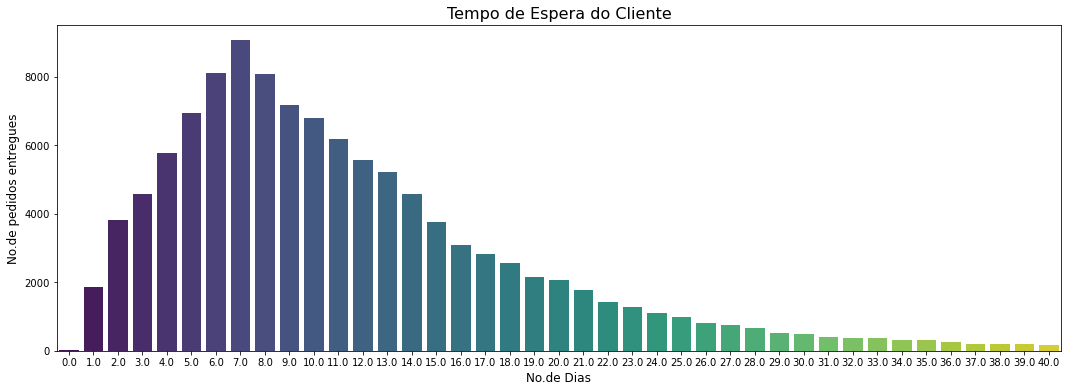

In [66]:
# Visualiza o tempo de espera do cliente a partir da data da compra
fig, ax = plt.subplots(figsize=(18,6))
sns.countplot(x='delivery_time',data=delivered_analysis[delivered_analysis['delivery_time']<=40],palette='viridis',ax=ax)
ax.set_title('Tempo de Espera do Cliente', fontsize=16)
ax.set_xlabel('No.de Dias', fontsize=12)
ax.set_ylabel('No.de pedidos entregues', fontsize=12)



In [67]:
delivered_analysis['delivery_time'].describe()

count    114652.000000
mean         11.987998
std           9.376750
min           0.000000
25%           6.000000
50%          10.000000
75%          15.000000
max         208.000000
Name: delivery_time, dtype: float64

Text(0, 0.5, 'No. de pedidos')

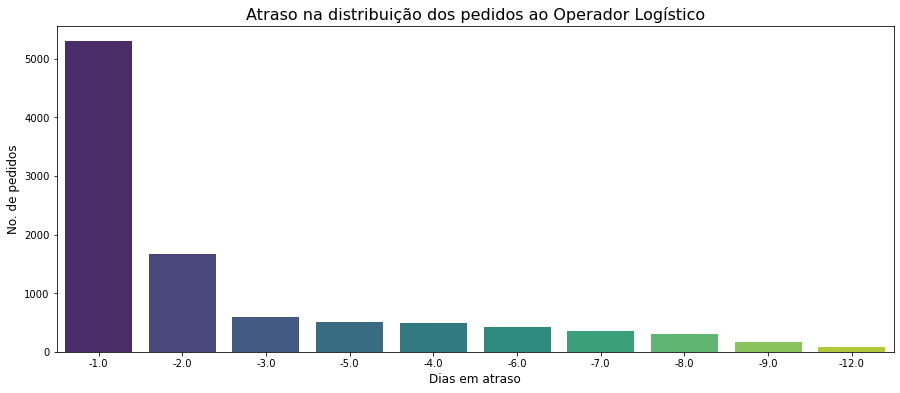

In [68]:
# Visualiza o número de dias de  atraso entre a data limite para o vendedor enviar o pedido para o parceiro logísitico 
# e a data do efetivo envio.
delay_process=list(delivered_analysis[delivered_analysis['delay_processing_time']<0]['delay_processing_time'].
                   value_counts().head(10).index)
delay_process_analysis = delivered_analysis[delivered_analysis['delay_processing_time'].isin(delay_process)]
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x='delay_processing_time', palette = 'viridis', data=delay_process_analysis, ax=ax,order = 
              delay_process_analysis['delay_processing_time'].value_counts().index)
ax.set_title('Atraso na distribuição dos pedidos ao Operador Logístico', fontsize=16)
ax.set_xlabel('Dias em atraso', fontsize=12)
ax.set_ylabel('No. de pedidos', fontsize=12)


Text(0, 0.5, 'No. de pedidos')

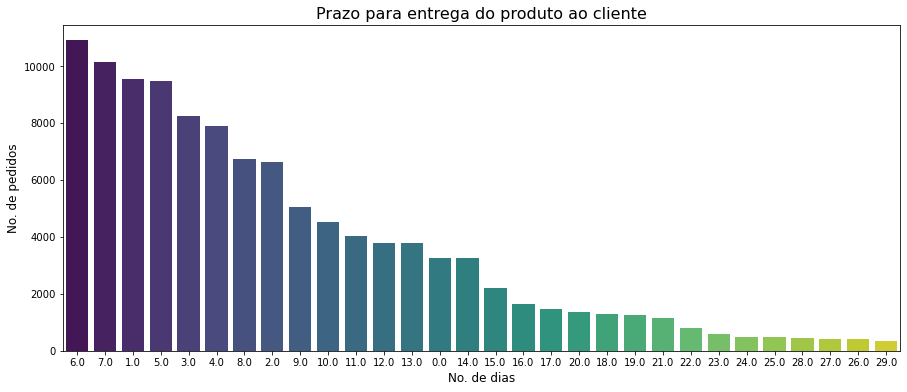

In [69]:
# Visualiza o número de dias utilizados pelo operador logístico para a entrega do pedido na casa do cliente  
ship30 = list(delivered_analysis['shipping time'].value_counts().sort_values(ascending=False).head(30).index)
ship30_analysis=delivered_analysis[delivered_analysis['shipping time'].isin(ship30)]
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x='shipping time', palette = 'viridis', data=ship30_analysis, ax=ax,order = 
              ship30_analysis['shipping time'].value_counts().index)
ax.set_title('Prazo para entrega do produto ao cliente', fontsize=16)
ax.set_xlabel('No. de dias', fontsize=12)
ax.set_ylabel('No. de pedidos', fontsize=12)


##### Observações:
* Mais de 5000 pedidos são encaminhados ao operador logístico com 1 dia de atraso e quase 2000 com 2 dias de atraso. 
* A transportadora (operador logístico) demora até 10 dias, para efetivar grande parte das entregas, concentrando um volume maior entre o sexto e sétimo dia.
* O tempo de espera da maior parte dos clientes varia em até 15 dias a partir da data da compra, porém podemos destacar que deste montante, uma boa parte recebe o produto entre o sexto e oitavo dia. 

### Variável Target - On_Time

In [70]:
# Vamos considerar baseado na informação acima que a entrega do produto ao cliente em até 10 dias está no prazo,
# e acima disso está em atraso.
# 1 significa 'on time'.
delivered_analysis['On_Time']=delivered_analysis['delivery_time'].apply(lambda x:1 if x <= 10 else 0)

In [71]:
ontime = delivered_analysis['On_Time'].sum()
al = delivered_analysis['On_Time'].count()
print("ontime_rate : %5.2f" % (ontime/al))


ontime_rate :  0.54


##### Observação
* Mais de 50% dos pedidos são entregues no prazo, ou seja, considerando até 10 dias a partir da data da compra.



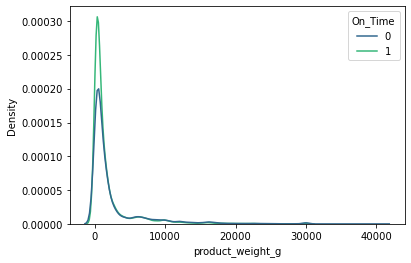

In [72]:
# O peso do produto influencia a entrega no prazo ?
sns.kdeplot(data = delivered_analysis, palette = 'viridis', x = 'product_weight_g', hue = 'On_Time');

#### Observação:
* O peso parece não influenciar na entrega no prazo.

In [73]:
delivered_analysis['processing time'].describe().to_frame()

,processing time
count,114652.000000
mean,2.796785
std,3.615923
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,125.000000


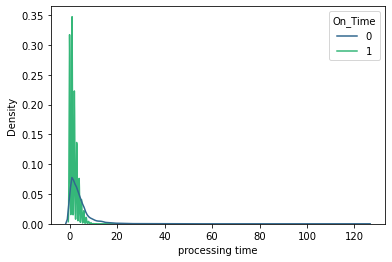

In [74]:
# O tempo de processamento do pedido influencia a entrega no prazo ?
sns.kdeplot(data = delivered_analysis,  palette = 'viridis', x = 'processing time', hue = 'On_Time');

##### Observação:
* O menor tempo de processamento influencia positivamente a entrega no prazo.

In [75]:
delivered_analysis['customer_state'].describe().to_frame()

,customer_state
count,114652
unique,27
top,SP
freq,48447


In [76]:
# A entrega no prazo está igualmente distribuida conforme a localidade(Estado) do cliente? Há diferenças discrepantes?
del_group1 = delivered_analysis.groupby(['On_Time','customer_state']).agg({'order_id' : 'nunique'}).reset_index()
del_group1

columns_name,On_Time,customer_state,order_id
0,0,AC,77
1,0,AL,373
2,0,AM,131
3,0,AP,63
4,0,BA,2668
5,0,CE,1107
6,0,DF,1098
7,0,ES,1320
8,0,GO,1370
9,0,MA,648


In [77]:
del_group2 = delivered_analysis.groupby('On_Time').agg({'order_id' : 'nunique'}).reset_index() 
del_group2

columns_name,On_Time,order_id
0,0,43943
1,1,51702


In [78]:
del_group3 = del_group1.merge(del_group2, on = 'On_Time')
del_group3

columns_name,On_Time,customer_state,order_id_x,order_id_y
0,0,AC,77,43943
1,0,AL,373,43943
2,0,AM,131,43943
3,0,AP,63,43943
4,0,BA,2668,43943
5,0,CE,1107,43943
6,0,DF,1098,43943
7,0,ES,1320,43943
8,0,GO,1370,43943
9,0,MA,648,43943


In [79]:
del_group4 = delivered_analysis.groupby('customer_state').agg({'order_id' : 'nunique'}).reset_index() 
del_group4

columns_name,customer_state,order_id
0,AC,80
1,AL,394
2,AM,144
3,AP,66
4,BA,3225
5,CE,1271
6,DF,2067
7,ES,1963
8,GO,1940
9,MA,708


In [80]:
del_group5 = del_group1.merge(del_group4, on = 'customer_state')
del_group5

columns_name,On_Time,customer_state,order_id_x,order_id_y
0,0,AC,77,80
1,1,AC,3,80
2,0,AL,373,394
3,1,AL,21,394
4,0,AM,131,144
5,1,AM,13,144
6,0,AP,63,66
7,1,AP,3,66
8,0,BA,2668,3225
9,1,BA,557,3225


In [81]:
del_group5['Percentual(%)'] = del_group5['order_id_x'] / del_group5['order_id_y'] * 100

In [82]:
# entrega no prazo = 1  
# entrega fora do prazo = 0

del_group5.columns = ['Status de Entrega no Prazo', 
                     'Localidade Cliente', 
                     'Total Por Categoria', 
                     'Total Geral', 
                     'Percentual(%)']
del_group5

,Status de Entrega no Prazo,Localidade Cliente,Total Por Categoria,Total Geral,Percentual(%)
0,0,AC,77,80,96.250000
1,1,AC,3,80,3.750000
2,0,AL,373,394,94.670051
3,1,AL,21,394,5.329949
4,0,AM,131,144,90.972222
5,1,AM,13,144,9.027778
6,0,AP,63,66,95.454545
7,1,AP,3,66,4.545455
8,0,BA,2668,3225,82.728682
9,1,BA,557,3225,17.271318


In [83]:
del_group5.columns

Index(['Status de Entrega no Prazo', 'Localidade Cliente',
       'Total Por Categoria', 'Total Geral', 'Percentual(%)'],
      dtype='object')

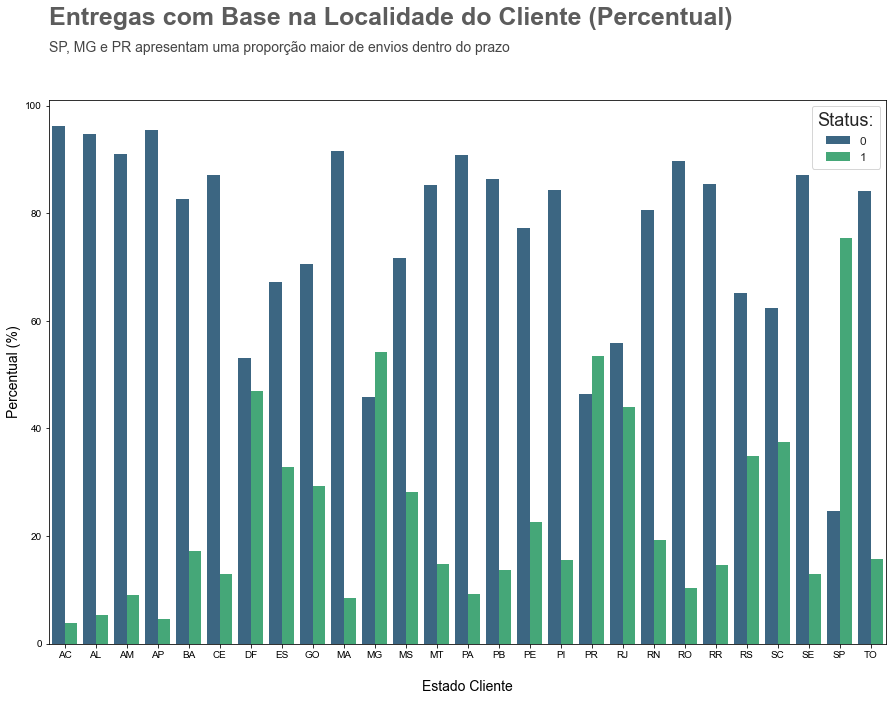

In [84]:
#Análise em Valores Percentuais

# Tamanho da figura
plt.figure(figsize = (15,10))

# Chart
chart = sns.barplot(x = 'Localidade Cliente', 
                    y = 'Percentual(%)', 
                    data = del_group5, 
                    hue = 'Status de Entrega no Prazo',
                    palette = 'viridis')

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nEstado Cliente", fontsize = 14)
chart.set_ylabel("Percentual (%)", fontsize = 14)

# Legenda
plt.legend(loc = 'upper right', 
           borderpad = 0.5, 
           labelspacing = 0.5, 
           fontsize = 12, 
           title = 'Status:')

# Título
chart.text(x = -0.5, 
           y = 115, 
           s = "Entregas com Base na Localidade do Cliente (Percentual)",
           fontsize = 25, 
           weight = 'bold', 
           alpha = .75)

# Sub-título
chart.text(x = -0.5, 
           y = 110,
           s = 'SP, MG e PR apresentam uma proporção maior de envios dentro do prazo',
           fontsize = 14, 
           alpha = .85);

#### Observações:
* Os Estados de SP, MG, PR e DF apresentaram a melhor performance na entrega no prazo. SP obteve quase 80% dos pedidos entregues no prazo, ou seja, considerando até 10 dias para entrega do produto a partir do momento da compra.
* Os Estados da região Norte e Nordeste tiveram os piores índices de entrega. Sendo assim, os clientes dessas regiões geralmente precisam esperar acima de 10 dias para receberem o produto.
* Na região Centro-Oeste somente DF alcançou uma performance razoável: acima de 40% de entregas no prazo.
* A localidade do cliente interfere na entrega no prazo, principalmente porque a maioria dos vendedores encontram-se no estado de São Paulo.
* Realmente existem diferenças discrepantes entre a entrega no prazo nos Estados da região Sudeste e Sul para os estados das demais regiões.

In [85]:
delivered_analysis['review_score'].describe().to_frame()

,review_score
count,114652.000000
mean,4.080234
std,1.347800
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [86]:
# A entrega no prazo interfere na pontuação do cliente?
del_group11 = delivered_analysis.groupby(['On_Time','review_score']).agg({'order_id' : 'nunique'}).reset_index()
del_group11

columns_name,On_Time,review_score,order_id
0,0,1,6378
1,0,2,1756
2,0,3,4429
3,0,4,9181
4,0,5,22312
5,1,1,2990
6,1,2,1180
7,1,3,3503
8,1,4,9721
9,1,5,34384


In [87]:
del_group12 = delivered_analysis.groupby('On_Time').agg({'order_id' : 'nunique'}).reset_index() 
del_group12

columns_name,On_Time,order_id
0,0,43943
1,1,51702


In [88]:
del_group13 = del_group11.merge(del_group12, on = 'On_Time')
del_group13

columns_name,On_Time,review_score,order_id_x,order_id_y
0,0,1,6378,43943
1,0,2,1756,43943
2,0,3,4429,43943
3,0,4,9181,43943
4,0,5,22312,43943
5,1,1,2990,51702
6,1,2,1180,51702
7,1,3,3503,51702
8,1,4,9721,51702
9,1,5,34384,51702


In [89]:
del_group14 = delivered_analysis.groupby('review_score').agg({'order_id' : 'nunique'}).reset_index() 
del_group14

columns_name,review_score,order_id
0,1,9368
1,2,2936
2,3,7932
3,4,18902
4,5,56696


In [90]:
del_group15 = del_group11.merge(del_group14, on = 'review_score')
del_group15

columns_name,On_Time,review_score,order_id_x,order_id_y
0,0,1,6378,9368
1,1,1,2990,9368
2,0,2,1756,2936
3,1,2,1180,2936
4,0,3,4429,7932
5,1,3,3503,7932
6,0,4,9181,18902
7,1,4,9721,18902
8,0,5,22312,56696
9,1,5,34384,56696


In [91]:
del_group15['Percentual(%)'] = del_group15['order_id_x'] / del_group15['order_id_y'] * 100
del_group15.columns = ['Status de Entrega no Prazo', 
                      'review_score', 
                      'Total Por Categoria', 
                      'Total Geral', 
                      'Percentual(%)']
del_group15

,Status de Entrega no Prazo,review_score,Total Por Categoria,Total Geral,Percentual(%)
0,0,1,6378,9368,68.082835
1,1,1,2990,9368,31.917165
2,0,2,1756,2936,59.809264
3,1,2,1180,2936,40.190736
4,0,3,4429,7932,55.837115
5,1,3,3503,7932,44.162885
6,0,4,9181,18902,48.571580
7,1,4,9721,18902,51.428420
8,0,5,22312,56696,39.353746
9,1,5,34384,56696,60.646254


In [92]:
del_group15.columns

Index(['Status de Entrega no Prazo', 'review_score', 'Total Por Categoria',
       'Total Geral', 'Percentual(%)'],
      dtype='object')

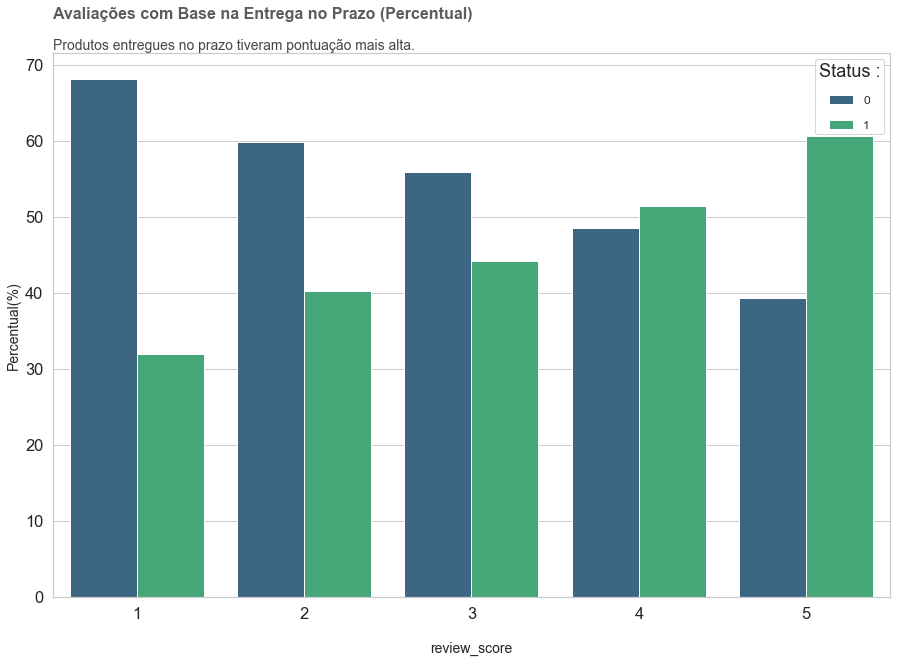

In [93]:
# Análise em Valores Percentuais
plt.figure(figsize = (15,10))
chart = sns.barplot(x = 'review_score', 
                    y = 'Percentual(%)', 
                    data = del_group15, 
                    hue = 'Status de Entrega no Prazo',
                    palette = 'viridis')
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nreview_score", fontsize = 14)
chart.set_ylabel("Percentual(%)", fontsize = 14)
plt.legend(loc = 'upper right', 
           borderpad = 0.3, 
           labelspacing = 1.2, 
           fontsize = 12, 
           title = 'Status :')
chart.text(x = -0.5, 
           y = 76, 
           s = "Avaliações com Base na Entrega no Prazo (Percentual)",
           fontsize = 16, 
           weight = 'bold', 
           alpha = .75)
chart.text(x = -0.5, 
           y = 72,
           s = "Produtos entregues no prazo tiveram pontuação mais alta.",
           fontsize = 14, 
           alpha = .85);

In [94]:
 #Análise dos pedidos entregues no prazo ao ano.
del_group16 = delivered_analysis.groupby(['On_Time','Year']).agg({'order_id' : 'nunique'}).reset_index()
del_group16

columns_name,On_Time,Year,order_id
0,0,2016,183
1,0,2017,21621
2,0,2018,22139
3,1,2016,81
4,1,2017,21462
5,1,2018,30159


In [95]:
del_group17 = delivered_analysis.groupby('On_Time').agg({'order_id' : 'nunique'}).reset_index() 
del_group17

columns_name,On_Time,order_id
0,0,43943
1,1,51702


In [96]:
del_group18 = del_group11.merge(del_group17, on = 'On_Time')
del_group18

columns_name,On_Time,review_score,order_id_x,order_id_y
0,0,1,6378,43943
1,0,2,1756,43943
2,0,3,4429,43943
3,0,4,9181,43943
4,0,5,22312,43943
5,1,1,2990,51702
6,1,2,1180,51702
7,1,3,3503,51702
8,1,4,9721,51702
9,1,5,34384,51702


In [97]:
del_group19 = delivered_analysis.groupby('Year').agg({'order_id' : 'nunique'}).reset_index() 
del_group19

columns_name,Year,order_id
0,2016,264
1,2017,43083
2,2018,52298


In [98]:
del_group20 = del_group16.merge(del_group19, on = 'Year')
del_group20

columns_name,On_Time,Year,order_id_x,order_id_y
0,0,2016,183,264
1,1,2016,81,264
2,0,2017,21621,43083
3,1,2017,21462,43083
4,0,2018,22139,52298
5,1,2018,30159,52298


In [99]:
del_group20['Percentual(%)'] = del_group20['order_id_x'] / del_group20['order_id_y'] * 100
del_group20.columns = ['Status de Entrega no Prazo', 
                      'Year', 
                      'Total Por Categoria', 
                      'Total Geral', 
                      'Percentual(%)']
del_group20

,Status de Entrega no Prazo,Year,Total Por Categoria,Total Geral,Percentual(%)
0,0,2016,183,264,69.318182
1,1,2016,81,264,30.681818
2,0,2017,21621,43083,50.184528
3,1,2017,21462,43083,49.815472
4,0,2018,22139,52298,42.332403
5,1,2018,30159,52298,57.667597


In [100]:
del_group20.columns

Index(['Status de Entrega no Prazo', 'Year', 'Total Por Categoria',
       'Total Geral', 'Percentual(%)'],
      dtype='object')

Text(-0.5, 76, ' Entregas no Prazo - Percentual por Ano')

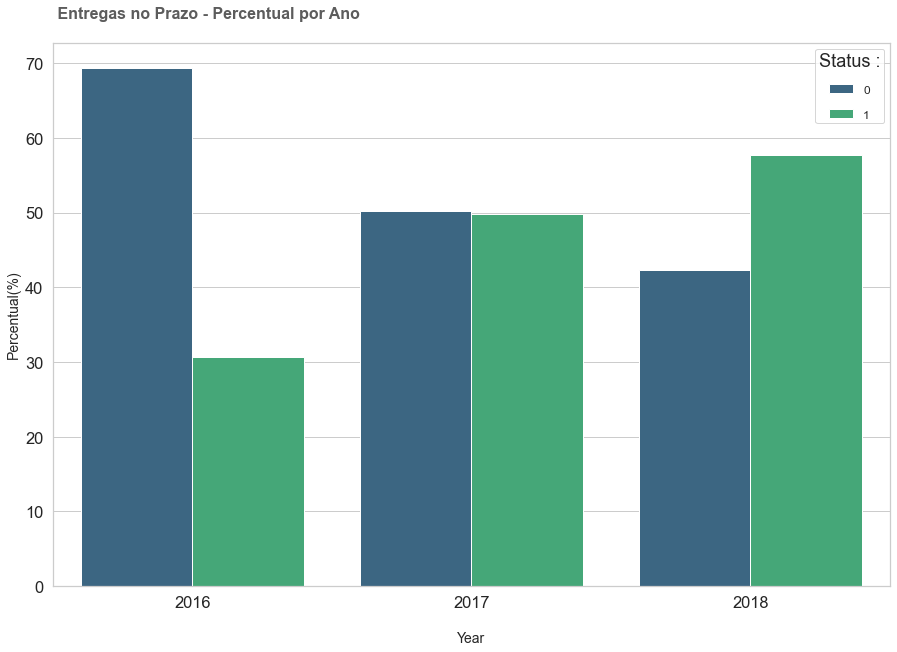

In [101]:
# Análise em Valores Percentuais
plt.figure(figsize = (15,10))
chart = sns.barplot(x = 'Year', 
                    y = 'Percentual(%)', 
                    data = del_group20, 
                    hue = 'Status de Entrega no Prazo',
                    palette = 'viridis')
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nYear", fontsize = 14)
chart.set_ylabel("Percentual(%)", fontsize = 14)
plt.legend(loc = 'upper right', 
           borderpad = 0.3, 
           labelspacing = 1.2, 
           fontsize = 12, 
           title = 'Status :')
chart.text(x = -0.5, 
           y = 76, 
           s = " Entregas no Prazo - Percentual por Ano",
           fontsize = 16, 
           weight = 'bold', 
           alpha = .75)


#### Variável Target
* No Prazo = 1    Fora do Prazo = 0

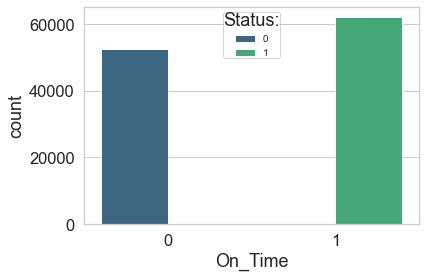

In [102]:
# Count Plot da variável target
sns.countplot(data = delivered_analysis, palette = 'viridis' , x = delivered_analysis['On_Time'], hue = 'On_Time'),
# Legenda
plt.legend(loc = 'upper center', 
           borderpad = 0.0, 
           labelspacing = 0.5, 
           fontsize = 10, 
           title = 'Status:')


* Observações:
* Quanto ao status da avaliação dado pelos clientes podemos destacar que mais de 60% dos produtos entregues fora do prazo receberam status 1, demonstrando a insatisfação desses clientes, motivado em parte ou totalmente devido a questão do atraso.
* No ano de 2017 (janeiro a dezembro) temos que 50% dos pedidos foram entregues no prazo.
* Nos anos de 2016 e 2018 os meses estão incompletos no dataset original, porém podemos notar que 2018 teve uma performance muito melhor se comparado a 2016. 



### Análise Bivariada - Mapa de Correlação

In [103]:
delivered_analysis.corr()

columns_name,price,freight_value,review_score,product_weight_g,payment_value,processing time,delay_processing_time,shipping time,delivery_time,Month,Year,On_Time
columns_name,,,,,,,,,,,,
price,1.000000,0.412379,0.003543,0.340015,0.739819,0.063764,-0.009982,0.040514,0.061259,0.000505,-0.000343,-0.051950
freight_value,0.412379,1.000000,-0.032545,0.610486,0.373384,0.088629,-0.004372,0.196954,0.213453,0.005920,0.037092,-0.204832
review_score,0.003543,-0.032545,1.000000,-0.025571,-0.081033,-0.153694,0.071454,-0.266798,-0.302990,0.027929,-0.015600,0.171036
product_weight_g,0.340015,0.610486,-0.025571,1.000000,0.306515,0.145909,-0.010998,0.029636,0.083447,-0.009509,-0.021634,-0.070667
payment_value,0.739819,0.373384,-0.081033,0.306515,1.000000,0.096678,-0.019103,0.026272,0.060712,0.004834,0.007087,-0.059715
processing time,0.063764,0.088629,-0.153694,0.145909,0.096678,1.000000,-0.393316,0.029827,0.411615,0.024152,-0.086209,-0.338417
delay_processing_time,-0.009982,-0.004372,0.071454,-0.010998,-0.019103,-0.393316,1.000000,0.005352,-0.146465,-0.007884,-0.016690,0.098692
shipping time,0.040514,0.196954,-0.266798,0.029636,0.026272,0.029827,0.005352,1.000000,0.921672,-0.071051,-0.017568,-0.583129
delivery_time,0.061259,0.213453,-0.302990,0.083447,0.060712,0.411615,-0.146465,0.921672,1.000000,-0.055481,-0.049939,-0.663718


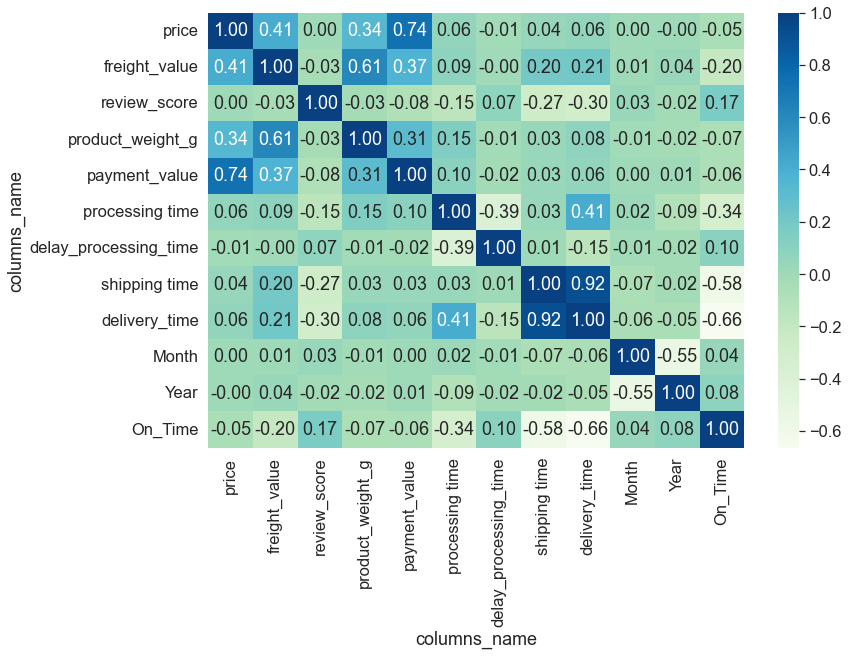

In [104]:
# 'shipping_time' = prazo de entrega, ou seja: nº de dias que a transportadora utiliza até a efetiva entrega do 
# pedido ao cliente;
# delivery_time' = tempo para entrega, ou seja: nº de dias que o cliente espera a partir da data da comopra até 
# a data efetiva da entrega.

# Mapa de correlação 
plt.figure(figsize = (12, 8))
sns.heatmap(delivered_analysis.corr(), cmap = 'GnBu', annot = True, fmt = '.2f');

##### Observações
* Shipping_time = prazo_de_entrega (op_logístico) e delivery_time = tempo para entrega(espera do cliente) tem forte correlação.
* processing_time e delay_Processing_time possuem correlação inversa

#### Decisões: 
* Na figura acima, os recursos que ultrapassaram o limite (+/- 0,05) na correlação com o recurso de destino (On_Time) serão escolhidos para próxima etapa de análise.
* São eles: freight_value, review_score, product_weight_g, payment_value,processing time, delay_processing_time*,delivery_time.
* As variáveis month e year serão descartadas pois não são relevantes para essa análise.
* A variável price será descartada, pois não ultrapassa o limite acima.
* A variável shipping_time foi descartada pela forte correlaçção com a variável delivery_time.
* A variável delay_processing_time* foi descartada porque só interessa os valores abaixo de zero, e isso diminuiria muito o dataset.

In [105]:
#alterando o nome das colunas e selecionando as colunas que farão parte da próxima análise, conforme decisão acima.
# Lembramos que estamos trabalhando somente com os pedidos delevered (entregues)

dados = delivered_analysis[['freight_value', 'review_score', 'product_weight_g', 'payment_value', 'processing time',
                         'delivery_time','On_Time']]


dados.rename({"freight_value": "frete",
           "product_weight_g": "peso_gr",
           "payment_value": "valor_pagamento",
           "processing time": "tempo_processamento",
           "delivery_time": "tempo_espera",
           "review_score": "avaliação_cliente",
           "On_Time": "entregue_no_prazo"},  axis=1, inplace=True)  

In [106]:
# "entregue_no_prazo" é nossa variável target
dados.head()

columns_name,frete,avaliação_cliente,peso_gr,valor_pagamento,tempo_processamento,tempo_espera,entregue_no_prazo
0,13.63,4,1300.0,397.26,1.0,6.0,1
1,13.63,4,1300.0,397.26,1.0,6.0,1
2,8.30,5,245.0,88.09,2.0,9.0,1
3,45.12,5,6550.0,194.12,3.0,13.0,0
4,42.85,5,7650.0,222.84,0.0,10.0,1


In [107]:
# Tipos de dados
dados.dtypes

columns_name
frete                  float64
avaliação_cliente        int64
peso_gr                float64
valor_pagamento        float64
tempo_processamento    float64
tempo_espera           float64
entregue_no_prazo        int64
dtype: object

### Exploração das Variáveis Numéricas

In [108]:
dados.describe()

columns_name,frete,avaliação_cliente,peso_gr,valor_pagamento,tempo_processamento,tempo_espera,entregue_no_prazo
count,114652.000000,114652.000000,114632.000000,114645.000000,114652.000000,114652.000000,114652.000000
mean,19.971373,4.080234,2104.258811,171.289152,2.796785,11.987998,0.542433
std,15.704413,1.347800,3770.582659,263.944905,3.615923,9.376750,0.498198
min,0.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000
25%,13.070000,4.000000,300.000000,60.690000,1.000000,6.000000,0.000000
50%,16.280000,5.000000,700.000000,108.000000,2.000000,10.000000,1.000000
75%,21.150000,5.000000,1800.000000,188.690000,4.000000,15.000000,1.000000
max,409.680000,5.000000,40425.000000,13664.080000,125.000000,208.000000,1.000000


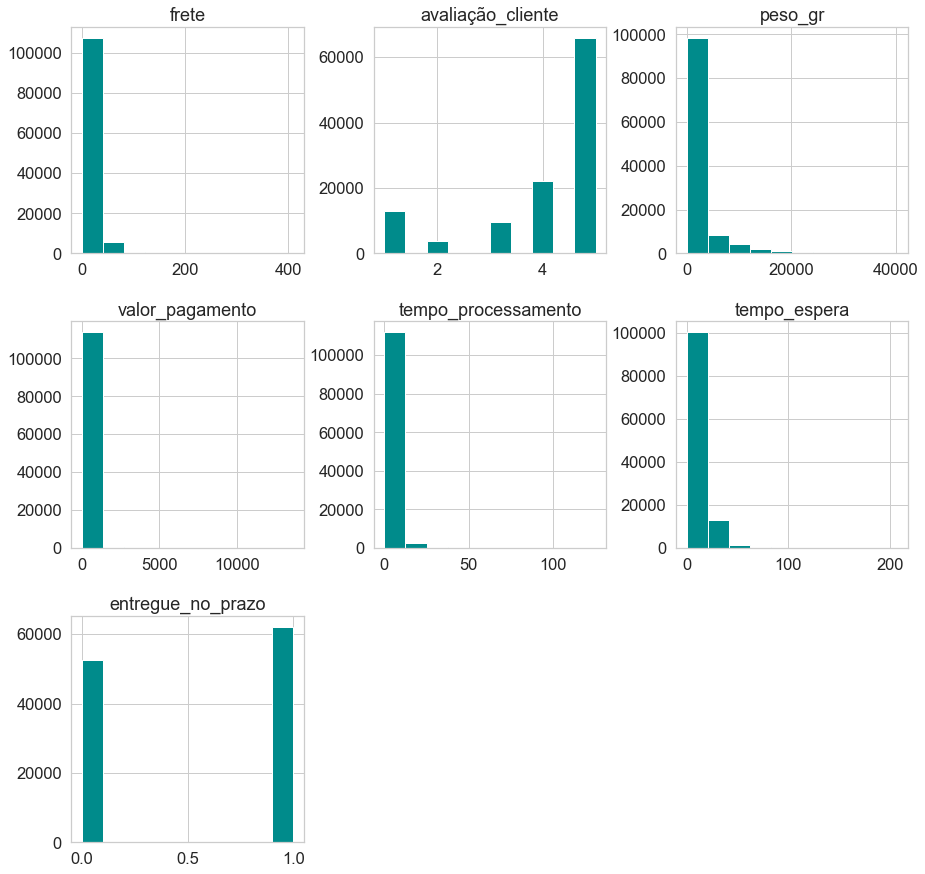

In [109]:
# Plot 
dados.hist(figsize = (15,15), bins = 10, color = 'darkcyan' ) 
plt.show()

In [110]:
dados['entregue_no_prazo'].value_counts()

1    62191
0    52461
Name: entregue_no_prazo, dtype: int64

In [111]:
dados.sample(5)

columns_name,frete,avaliação_cliente,peso_gr,valor_pagamento,tempo_processamento,tempo_espera,entregue_no_prazo
33808,14.52,5,800.0,98.84,3.0,8.0,1
67075,13.23,5,500.0,58.13,0.0,5.0,1
51149,15.45,5,150.0,115.34,3.0,26.0,0
29832,17.03,1,550.0,217.02,3.0,23.0,0
21772,20.87,5,1550.0,75.03,1.0,6.0,1


### Verificando a Relação Entre Atributos

In [112]:
# Correlação entre as variáveis
dados.corr()

columns_name,frete,avaliação_cliente,peso_gr,valor_pagamento,tempo_processamento,tempo_espera,entregue_no_prazo
columns_name,,,,,,,
frete,1.000000,-0.032545,0.610486,0.373384,0.088629,0.213453,-0.204832
avaliação_cliente,-0.032545,1.000000,-0.025571,-0.081033,-0.153694,-0.302990,0.171036
peso_gr,0.610486,-0.025571,1.000000,0.306515,0.145909,0.083447,-0.070667
valor_pagamento,0.373384,-0.081033,0.306515,1.000000,0.096678,0.060712,-0.059715
tempo_processamento,0.088629,-0.153694,0.145909,0.096678,1.000000,0.411615,-0.338417
tempo_espera,0.213453,-0.302990,0.083447,0.060712,0.411615,1.000000,-0.663718
entregue_no_prazo,-0.204832,0.171036,-0.070667,-0.059715,-0.338417,-0.663718,1.000000


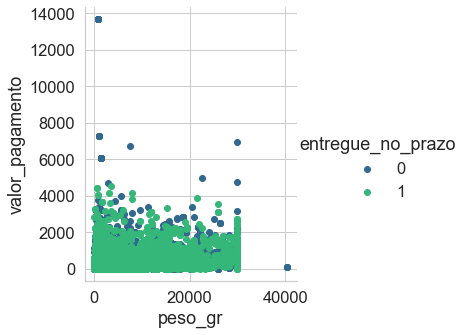

In [113]:
# Facetgrid -> coloca vários gráficos na mesma área de plotagem
sns.FacetGrid(dados, hue = 'entregue_no_prazo',  palette = 'viridis', size = 5).map(plt.scatter, 'peso_gr', 'valor_pagamento').add_legend()

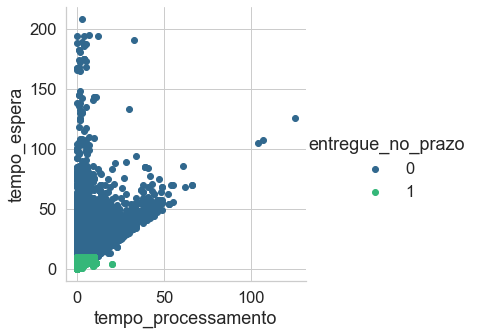

In [114]:
# Facetgrid -> coloca vários gráficos na mesma área de plotagem
sns.FacetGrid(dados, hue = 'entregue_no_prazo',  palette = 'viridis',size = 5).map(plt.scatter, 'tempo_processamento', 'tempo_espera').add_legend()

### Verificando Valores Ausentes e Registros Duplicados

In [115]:
# Verificando valores ausentes
dados[dados.isnull().values]

columns_name,frete,avaliação_cliente,peso_gr,valor_pagamento,tempo_processamento,tempo_espera,entregue_no_prazo
1372,27.00,5,NaN,1961.00,3.0,8.0,1
10611,14.52,5,NaN,20.00,1.0,11.0,0
10612,14.52,5,NaN,20.00,1.0,11.0,0
10613,14.52,5,NaN,3.52,1.0,11.0,0
15805,14.52,5,NaN,43.52,9.0,10.0,1
22067,10.96,5,NaN,39.96,3.0,5.0,1
27152,14.52,5,NaN,43.52,3.0,10.0,1
37601,11.85,5,NaN,50.85,2.0,9.0,1
42261,24.84,4,NaN,53.84,0.0,35.0,0
43779,16.05,5,NaN,45.05,2.0,16.0,0


In [116]:
# Verificando registros duplicados (complete cases)
# Complete cases também se refere a linhas onde não há valores ausentes
dados[dados.duplicated(keep = False)]

columns_name,frete,avaliação_cliente,peso_gr,valor_pagamento,tempo_processamento,tempo_espera,entregue_no_prazo
0,13.63,4,1300.0,397.26,1.0,6.0,1
1,13.63,4,1300.0,397.26,1.0,6.0,1
6,13.20,1,950.0,462.70,4.0,5.0,1
7,13.20,1,950.0,462.70,4.0,5.0,1
9,13.20,1,950.0,462.70,4.0,5.0,1
...,...,...,...,...,...,...,...
118114,11.62,3,1000.0,699.72,1.0,14.0,0
118115,11.62,3,1000.0,699.72,1.0,14.0,0
118116,11.62,3,1000.0,699.72,1.0,14.0,0
118118,53.21,5,700.0,176.20,9.0,20.0,0


### Tratamento de Registros Duplicados

In [117]:
dados.shape

(114652, 7)

In [118]:
# Remove registros duplicados (remove uma das duplicatas)
dados = dados.drop_duplicates()
print(dados.shape)

(101648, 7)


### Tratamento de Outliers

In [119]:
dados.describe()

columns_name,frete,avaliação_cliente,peso_gr,valor_pagamento,tempo_processamento,tempo_espera,entregue_no_prazo
count,101648.000000,101648.000000,101631.000000,101643.000000,101648.000000,101648.000000,101648.000000
mean,20.189637,4.115054,2111.076532,157.826419,2.745317,12.092751,0.538545
std,15.853220,1.315265,3777.296145,216.959357,3.561085,9.505227,0.498515
min,0.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000
25%,13.267500,4.000000,300.000000,58.280000,1.000000,6.000000,0.000000
50%,16.400000,5.000000,700.000000,103.140000,2.000000,10.000000,1.000000
75%,21.300000,5.000000,1800.000000,176.880000,4.000000,15.000000,1.000000
max,409.680000,5.000000,40425.000000,13664.080000,125.000000,208.000000,1.000000


#### Será que os valores extremos são mesmo outliers?

<AxesSubplot:xlabel='valor_pagamento'>

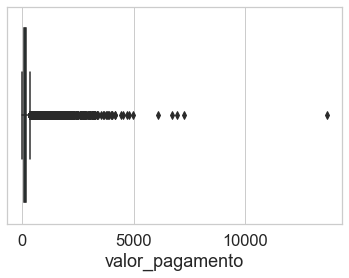

In [120]:
# Boxplot
sns.boxplot(dados.valor_pagamento, color = 'darkcyan')

In [121]:
# Contagem de frequência por valor
dados.valor_pagamento.sort_values(ascending = False).head()

35501    13664.08
22374     7274.88
58626     6929.31
40678     6726.66
9002      6081.54
Name: valor_pagamento, dtype: float64

In [122]:
# Mantém somente os registros onde o valor for menor ou igual a 8000
dados = dados[dados.valor_pagamento <= 8000]
dados.shape

(101642, 7)

<AxesSubplot:xlabel='frete'>

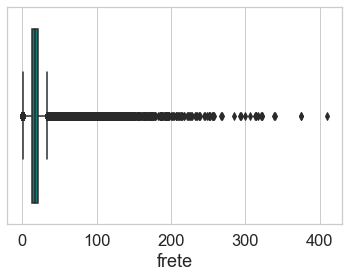

In [123]:
# Boxplot
sns.boxplot(dados.frete, color = 'darkcyan')

In [124]:
# Contagem de frequência por valor
dados.frete.sort_values(ascending = False).head()

88417    409.68
19851    375.28
6644     375.28
71284    339.59
84391    338.30
Name: frete, dtype: float64

In [125]:
# Mantém somente os registros onde o valor for menor  200
dados = dados[dados.frete < 200]
dados.shape

(101585, 7)

<AxesSubplot:xlabel='frete'>

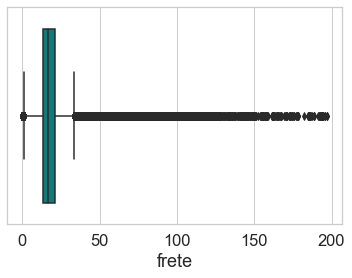

In [126]:
# Boxplot
sns.boxplot(dados.frete, color = 'darkcyan')

<AxesSubplot:xlabel='peso_gr'>

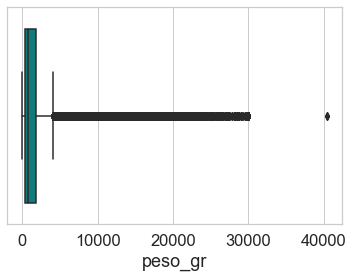

In [127]:
# Boxplot
sns.boxplot(dados.peso_gr, color = 'darkcyan')

In [128]:
# Contagem de frequência por valor
dados.peso_gr.sort_values(ascending = False).head()

11358     40425.0
13535     40425.0
105003    40425.0
14138     30000.0
33218     30000.0
Name: peso_gr, dtype: float64

In [129]:
# Mantém somente os registros onde o valor for menor 20000
dados = dados[dados.peso_gr < 20000]
dados.shape

(100739, 7)

<AxesSubplot:xlabel='peso_gr'>

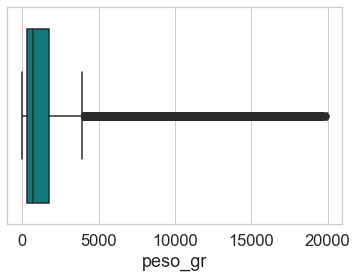

In [130]:
# Boxplot
sns.boxplot(dados.peso_gr, color = 'darkcyan')

<AxesSubplot:xlabel='tempo_processamento'>

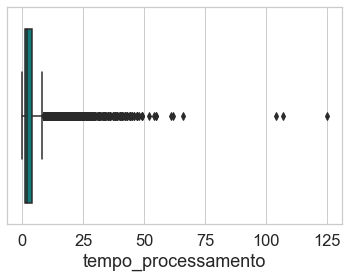

In [131]:
# Boxplot
sns.boxplot(dados.tempo_processamento, color = 'darkcyan')

In [132]:
# Mantém somente os registros onde o valor for menor ou igual a 40
dados = dados[dados.tempo_processamento <= 40]
dados.shape

(100682, 7)

<AxesSubplot:xlabel='tempo_processamento'>

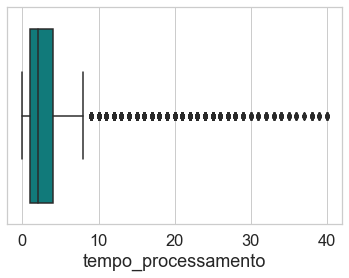

In [133]:
# Boxplot
sns.boxplot(dados.tempo_processamento, color = 'darkcyan')

In [134]:
# Contagem de frequência por valor
dados.tempo_processamento.sort_values(ascending = False).head()

49525    40.0
4828     40.0
81866    40.0
65143    40.0
23409    40.0
Name: tempo_processamento, dtype: float64

<AxesSubplot:xlabel='tempo_espera'>

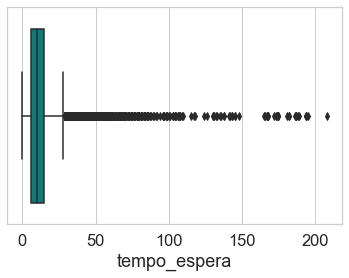

In [135]:
# Boxplot
sns.boxplot(dados.tempo_espera, color = 'darkcyan')

In [136]:
# Contagem de frequência por valor
dados.tempo_espera.sort_values(ascending = False).head()

831       208.0
55148     195.0
112186    194.0
27360     194.0
14787     194.0
Name: tempo_espera, dtype: float64

In [137]:
# Mantém somente os registros onde o valor for menor ou igual  80
dados = dados[dados.tempo_espera <= 80]
dados.shape

(100581, 7)

<AxesSubplot:xlabel='tempo_espera'>

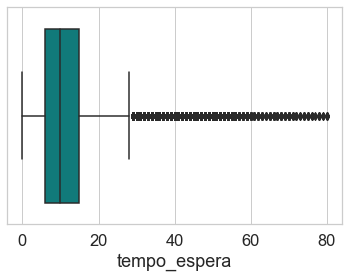

In [138]:
# Boxplot
sns.boxplot(dados.tempo_espera, color = 'darkcyan')

In [139]:
dados.describe()

columns_name,frete,avaliação_cliente,peso_gr,valor_pagamento,tempo_processamento,tempo_espera,entregue_no_prazo
count,100581.000000,100581.000000,100581.000000,100581.000000,100581.000000,100581.000000,100581.000000
mean,19.556460,4.118790,1907.932085,153.114990,2.696871,11.927770,0.540460
std,13.158698,1.311841,3087.137396,198.153054,3.315691,8.618433,0.498363
min,0.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000
25%,13.210000,4.000000,300.000000,58.090000,1.000000,6.000000,0.000000
50%,16.330000,5.000000,700.000000,102.340000,2.000000,10.000000,1.000000
75%,21.150000,5.000000,1750.000000,174.410000,4.000000,15.000000,1.000000
max,194.220000,5.000000,19950.000000,7274.880000,40.000000,80.000000,1.000000


### Tratamento de Valores Ausentes

In [140]:
# Verifica se há valor ausente
dados.isnull().values.any()

False

In [141]:
# Lista os valores ausentes
dados[dados.isnull().values]

columns_name,frete,avaliação_cliente,peso_gr,valor_pagamento,tempo_processamento,tempo_espera,entregue_no_prazo


In [142]:
dados.sample(10)

columns_name,frete,avaliação_cliente,peso_gr,valor_pagamento,tempo_processamento,tempo_espera,entregue_no_prazo
2664,13.52,5,2200.0,85.52,3.0,11.0,0
110500,11.85,3,600.0,56.35,4.0,8.0,1
40468,16.44,5,1550.0,292.68,0.0,6.0,1
107315,13.71,3,900.0,53.70,1.0,7.0,1
61053,20.08,1,1400.0,139.98,1.0,34.0,0
115884,8.58,5,750.0,68.57,3.0,6.0,1
6378,16.11,5,700.0,56.01,4.0,13.0,0
81717,20.04,1,2400.0,419.04,3.0,10.0,1
1228,25.63,1,300.0,50.62,4.0,41.0,0
73045,29.10,4,5650.0,541.23,4.0,9.0,1


In [143]:
dados.shape

(100581, 7)

In [144]:
dados.to_csv('dados/dados.csv', sep = ',', encoding = 'utf-8')